## 평균 배달거리 데이터를 가지고 배달거리에 따르는 주문수 예측하기

In [1]:
from pyspark.sql import SparkSession

In [2]:
MAX_MEMORY = "6g"
spark = SparkSession.builder.appName("distance-data-analysis")\
                            .config("spark.executor.memory", MAX_MEMORY)\
                            .config("spark.driver.memory", MAX_MEMORY)\
                            .getOrCreate()

22/04/22 21:33:18 WARN Utils: Your hostname, devkhk-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 172.30.1.27 instead (on interface en0)
22/04/22 21:33:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/22 21:33:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [10]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, FloatType, IntegerType

In [14]:
schema = StructType([
    StructField("year", IntegerType()),
    StructField("month", IntegerType()),
    StructField("menu", StringType()),
    StructField("city", StringType()),
    StructField("region", StringType()),
    StructField("delivery_count", IntegerType()),
    StructField("distance", FloatType()),
])

In [18]:
distance_dir = "/Users/devkhk/Documents/public-data-engineering/data/distance_data/*"

In [19]:
distance_df = spark.read.csv(f"file:///{distance_dir}", schema=schema)

In [20]:
distance_df.show()

+----+-----+------------+------+---------------+--------------+--------+
|year|month|        menu|  city|         region|delivery_count|distance|
+----+-----+------------+------+---------------+--------------+--------+
|2020|    1| 카페/디저트|강원도|         강릉시|           188| 1411.56|
|2020|    1| 카페/디저트|강원도|         삼척시|            82| 1036.74|
|2020|    1| 카페/디저트|강원도|         원주시|          1737| 1075.13|
|2020|    1|      도시락|경기도|  고양시 덕양구|           835| 1563.44|
|2020|    1| 돈까스/일식|경기도|  고양시 덕양구|          2156| 1330.03|
|2020|    1|배달전문업체|경기도|  고양시 덕양구|           165| 1469.38|
|2020|    1|        분식|경기도|  고양시 덕양구|          6072| 1388.12|
|2020|    1| 아시안/양식|경기도|  고양시 덕양구|          1074| 1928.05|
|2020|    1|        야식|경기도|  고양시 덕양구|          2105| 1435.27|
|2020|    1|   족발/보쌈|경기도|  고양시 덕양구|          3220| 1434.42|
|2020|    1|        중식|경기도|  고양시 덕양구|          1342| 1334.88|
|2020|    1|        찜탕|경기도|  고양시 덕양구|           426| 1259.92|
|2020|    1|        치킨|경기도|  고양시 덕양구|         1088

In [21]:
distance_df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- menu: string (nullable = true)
 |-- city: string (nullable = true)
 |-- region: string (nullable = true)
 |-- delivery_count: integer (nullable = true)
 |-- distance: float (nullable = true)



In [23]:
distance_df.createOrReplaceTempView("distance")

In [25]:
query = """
SELECT
    year,
    month,
    distance,
    delivery_count
FROM
    distance
"""

selected_df = spark.sql(query)
selected_df.show()


+----+-----+--------+--------------+
|year|month|distance|delivery_count|
+----+-----+--------+--------------+
|2020|    1| 1411.56|           188|
|2020|    1| 1036.74|            82|
|2020|    1| 1075.13|          1737|
|2020|    1| 1563.44|           835|
|2020|    1| 1330.03|          2156|
|2020|    1| 1469.38|           165|
|2020|    1| 1388.12|          6072|
|2020|    1| 1928.05|          1074|
|2020|    1| 1435.27|          2105|
|2020|    1| 1434.42|          3220|
|2020|    1| 1334.88|          1342|
|2020|    1| 1259.92|           426|
|2020|    1| 1218.42|         10881|
|2020|    1| 1644.63|           287|
|2020|    1|  876.33|          4008|
|2020|    1| 1015.67|          2217|
|2020|    1| 1417.51|          5415|
|2020|    1|  1412.6|          1548|
|2020|    1| 1440.51|            65|
|2020|    1| 1578.42|            92|
+----+-----+--------+--------------+
only showing top 20 rows



In [26]:
selected_df.describe().show()

+-------+------------------+-----------------+------------------+------------------+
|summary|              year|            month|          distance|    delivery_count|
+-------+------------------+-----------------+------------------+------------------+
|  count|             14606|            14606|             14606|             14606|
|   mean|2020.0310831165275|6.488429412570176|1418.6040808865587|1560.6607558537587|
| stddev|0.7125753719707325| 3.42027649601466| 808.7124034941143|3118.6325121177974|
|    min|              2019|                1|               0.0|                 1|
|    max|              2021|               12|           19466.0|             83573|
+-------+------------------+-----------------+------------------+------------------+



In [28]:
# 데이터 분석 전 잘못된 정보들 파악하기 위한 selected 테이블 조회
selected_df.createOrReplaceTempView("selected")

### 쿼리 작성에 도움이 된 링크
http://oskardevelopers.blogspot.com/2015/10/it-database-sql-case-count.html

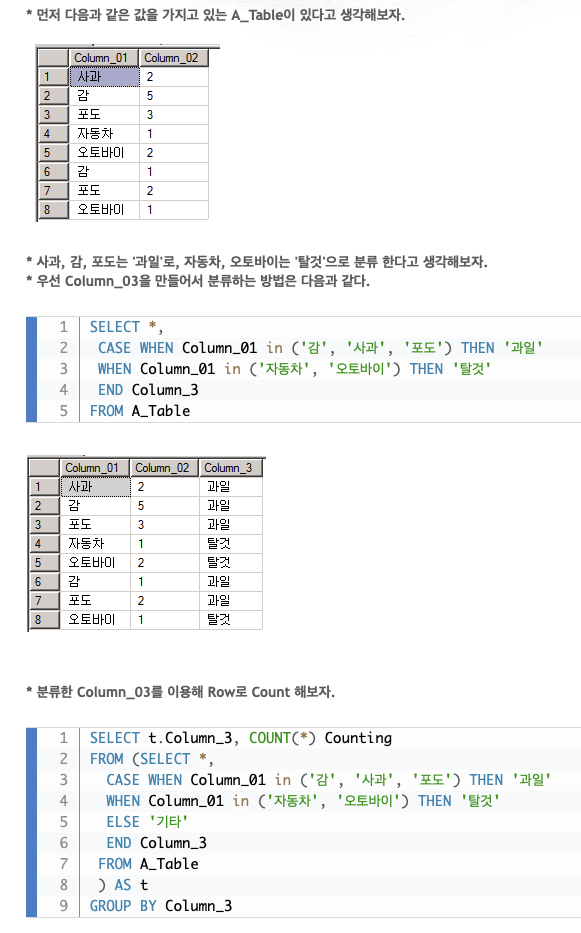

In [253]:
query = """
SELECT 
    t.distance_divide, COUNT(*) as count
FROM 
    (SELECT
            distance,
            CASE WHEN (distance = 0) THEN '0meter'
                WHEN (distance > 0 and distance <= 50) THEN '50meter'
                WHEN (distance > 50 and distance <= 100) THEN '100meter'
                WHEN (distance > 100 and distance <= 150) THEN '150meter'
                WHEN (distance > 150 and distance <= 200) THEN '200meter'
                WHEN (distance > 200 and distance <= 300) THEN '300meter'
                WHEN (distance > 300 and distance <= 500) THEN '500meter'
                WHEN (distance > 500 and distance<= 1000) THEN '1000meter'
                WHEN (distance > 1000 and distance <= 1500) THEN '1500meter'
                WHEN (distance > 1500 and distance <= 2000) THEN '2000meter'
                WHEN (distance > 2000 and distance <= 3000) THEN '3000meter'
                WHEN (distance > 3000 and distance <= 5000) THEN '5000meter'
            ELSE 'overmeter'
            END distance_divide
    FROM selected ) as t
GROUP BY 
    distance_divide
ORDER BY
    count
"""

In [255]:
spark.sql(query).show()
# 1키로 이상 ~ 3키로 이내 데이터만 추출하기로 결정

+---------------+-----+
|distance_divide|count|
+---------------+-----+
|        50meter|    2|
|       150meter|    4|
|       100meter|    5|
|       200meter|    7|
|         0meter|   10|
|       300meter|   21|
|      overmeter|   91|
|       500meter|  161|
|      5000meter|  191|
|      3000meter| 1065|
|      1000meter| 2826|
|      2000meter| 3477|
|      1500meter| 6746|
+---------------+-----+



In [305]:
query = """
SELECT
    distance,
    delivery_count
FROM
    selected
WHERE
    distance >= 500 
    and distance <= 3000
    and delivery_count > 100
    and delivery_count < 500
"""

In [306]:
comb_df = spark.sql(query)
comb_df.show()

+--------+--------------+
|distance|delivery_count|
+--------+--------------+
| 1411.56|           188|
| 1469.38|           165|
| 1259.92|           426|
| 1644.63|           287|
| 1400.16|           122|
| 1016.15|           189|
|  1574.8|           227|
|  1490.6|           126|
|  1292.2|           251|
| 1243.53|           458|
| 1127.09|           235|
| 1960.86|           200|
| 2323.32|           190|
| 1667.06|           151|
|  553.48|           116|
| 1156.98|           296|
|  746.17|           375|
|  1394.0|           471|
| 1517.11|           204|
| 1127.78|           196|
+--------+--------------+
only showing top 20 rows



In [307]:
train_df, test_df = comb_df.randomSplit([.8, .2], seed=1)

In [308]:
from pyspark.ml.feature import VectorAssembler

In [309]:
vassembler = VectorAssembler(inputCols=['distance'], outputCol="features")

In [310]:
vtrain_df = vassembler.transform(train_df)

In [311]:
vtrain_df.show()

+--------+--------------+-------------------+
|distance|delivery_count|           features|
+--------+--------------+-------------------+
|  502.13|           410|[502.1300048828125]|
|  505.24|           188| [505.239990234375]|
|  526.11|           395|[526.1099853515625]|
|  529.63|           219|[529.6300048828125]|
|  531.77|           204|  [531.77001953125]|
|  532.52|           343|  [532.52001953125]|
|  535.97|           444| [535.969970703125]|
|  542.93|           375|[542.9299926757812]|
|  543.69|           324|[543.6900024414062]|
|  544.76|           299| [544.760009765625]|
|  545.66|           322|[545.6599731445312]|
|  551.29|           418|[551.2899780273438]|
|  559.76|           114| [559.760009765625]|
|  562.53|           123| [562.530029296875]|
|  564.14|           138|[564.1400146484375]|
|   566.0|           119|            [566.0]|
|  571.81|           412|[571.8099975585938]|
|  574.06|           101|[574.0599975585938]|
|  578.55|           169|[578.5499

In [312]:
from pyspark.ml.regression import LinearRegression

In [313]:
lr = LinearRegression(
    maxIter=50,
    regParam=0.2,
    labelCol="delivery_count"
)

In [314]:
model = lr.fit(vtrain_df)

In [315]:
vtest_df = vassembler.transform(test_df)

In [316]:
predictions = model.transform(vtest_df)

In [317]:
predictions.select(["distance", "delivery_count", "prediction"]).show()

+--------+--------------+------------------+
|distance|delivery_count|        prediction|
+--------+--------------+------------------+
|  531.51|           116| 269.9802698114478|
|  553.48|           116|270.06187631092536|
|  557.17|           351|   270.07558266431|
|  557.65|           224|270.07736575757247|
|  562.19|           345|270.09422930825826|
|  603.93|           421|270.24927068438404|
|  618.37|           238| 270.3029074446517|
|  621.87|           211| 270.3159080422415|
|  653.41|           465| 270.4330619171916|
|  655.38|           229| 270.4403795142969|
|  682.22|           108| 270.5400753985696|
|  693.88|           242|  270.583386087785|
|  704.68|           238| 270.6235021721482|
|  725.45|           173| 270.7006515052507|
|  751.21|           228|270.79633593978576|
|  751.38|           151| 270.7969673339035|
|   760.7|           311| 270.8315860952625|
|  761.08|           135| 270.8329976068521|
|  783.12|           261|270.91486414548694|
|  805.62|

In [318]:
model.summary.r2

0.00021413147269100374

## 요약
거리 데이터가 이미 평균 데이터이고, 지역마다 거리에 따른 배달요청수가 매우 불규칙적이라 선형회귀를 사용하기에는 문제가 많았다.
대략적으로 1키로 이상 ~ 3키로 이내 배달 요청이 가장 많은 것은 확인이 가능했고 주어진 데이터표를 가지고 배달 요청값을 추출하는 것은 무리가 있다고 판단된다.

In [319]:
spark.stop()